# Mapping Signal Groups

In [73]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import xarray as xr
import zarr
import json
import pandas as pd
from pathlib import Path
from src.archive.transforms import PipelineRegistry

def load_source(path):
    store = zarr.open(path)
    keys = list(store.keys())
    dt = {key: xr.open_zarr(path + '/'+ key) for key in keys}
    return dt
    

def make_channel_df(dataset):
    items = []
    for key, ds in dataset.data_vars.items():
        item = dict(name=ds.attrs['uda_name'], description=ds.attrs['description'])
        items.append(item)

    df = pd.DataFrame(items)
    return df

def group_signals_by_source(source, dt) -> xr.Dataset:
    datasets = []
    for name, ds in dt.items():
        ds = ds.squeeze()

        # Drop error if all zeros
        if (ds['error'].values == 0).all():
            ds = ds.drop_vars('error')

        # Rename variables
        new_names = {}
        if 'error' in ds:
            new_names['data'] = '_'.join([name, 'data'])
            new_names['error'] = '_'.join([name, 'error'])
        else:
            name = name + '_' if name == 'time' else name
            new_names['data'] = name

        ds = ds.rename(new_names)

        # Update attributes
        attrs = ds.attrs
        attrs['name'] = source + '/' + new_names['data']
        ds[new_names['data']].attrs = attrs
        datasets.append(ds)

    dataset = xr.merge(datasets)
    dataset.attrs = {}

    return dataset

def tensorise_group(dataset: xr.Dataset, stem: str) -> xr.Dataset:
    dim_name = f'{stem}_channel'
    group_keys = [key for key in dataset.data_vars.keys() if stem in key]
    channels = [dataset[key] for key in group_keys]
    dataset[stem] = xr.combine_nested(channels, concat_dim=dim_name)
    dataset[stem] = dataset[stem].assign_coords({dim_name: group_keys})
    dataset[stem] = dataset[stem].chunk('auto')
    dataset = dataset.drop_vars(group_keys)
    return dataset

def print_datasets(dt):
    for key, ds in dt.items():
        print(ds.sizes, key, ds.attrs['description'])

pipelines = PipelineRegistry()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### ABM - Needs Review

In [89]:
source = 'abm'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
print_datasets(dataset)
for key, ds in dataset.items():
    print(ds.coords)

Frozen({}) calib_shot Shot used for calibration (obsolete)
Frozen({'dim_0': 32}) channel_status Failed = 0, OK = 1
Frozen({'dim_0': 32}) channel_type Channel type (0 = poloidal, 1 = co-tangential, -1 = counter-tangential)
Frozen({'dim_0': 32}) gain Gain of pre-amplifiers
Frozen({'dim_0': 32, 'time': 7500}) i-bol Incident powers (x - channel)
Frozen({'dim_0': 32}) km Sensitivities
Frozen({}) passnumber Analysis pass number
Frozen({'dim_0': 32}) phi-chords Toroidal angle of chord end-points (zero at poloidal array)
Frozen({'dim_0': 32}) phi-slits Toroidal angle of slits (zero at poloidal array)
Frozen({'time': 7500}) prad_pol Total radiated power from poloidal array
Frozen({'dim_0': 32}) r-chords Major radius of chord end-points
Frozen({'dim_0': 32}) r-slits Major radius of slits
Frozen({'chord': 11}) r_tco_emis Minor radii of inverted emissivity profile from co-tangential array
Frozen({'dim_0': 32}) rbm Resistance of bolometer elements
Frozen({}) status No data -1, bad data 0, good data

### ADA

In [72]:
source = 'ada'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
# dataset = group_signals_by_source(source, dt)
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset

ValueError: cannot re-index or align objects with conflicting indexes found for the following coordinates: 'dim_0' (2 conflicting indexes), 'time' (2 conflicting indexes)
Conflicting indexes may occur when
- they relate to different sets of coordinate and/or dimension names
- they don't have the same type
- they may be used to reindex data along common dimensions

### ADG

In [7]:
source = 'adg'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 5kB
Dimensions:                (time: 388)
Coordinates:
  * time                   (time) float32 2kB -0.09512 -0.09307 ... 0.6982
Data variables:
    adg/density_gradient   (time) float32 2kB dask.array<chunksize=(388,), meta=np.ndarray>
    adg/gradient_position  (time) float32 2kB dask.array<chunksize=(388,), meta=np.ndarray>
    adg/passnumber         float32 4B dask.array<chunksize=(), meta=np.ndarray>
    adg/status             float32 4B dask.array<chunksize=(), meta=np.ndarray>

### AGA

In [8]:
source = 'aga'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 2MB
Dimensions:             (time: 8000, time_fig: 127000)
Coordinates:
  * time                (time) float32 32kB -0.1 -0.0998 -0.0996 ... 1.5 1.5
  * time_fig            (time_fig) float32 508kB -2.5 -2.5 -2.5 ... 10.2 10.2
Data variables: (12/25)
    aga/bc11            (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    aga/bc5             (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    aga/fig             (time_fig) float32 508kB dask.array<chunksize=(63500,), meta=np.ndarray>
    aga/fig_raw         (time_fig) float32 508kB dask.array<chunksize=(63500,), meta=np.ndarray>
    aga/hecc            (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    aga/helios          (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    ...                  ...
    aga/outboard_total  (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    aga/passnumber      int32 4B dask.array<chunksize=(), meta=np.ndarray>
    aga/status          int32 4B dask.array<chunksize=(), meta=np.ndarray>
    aga/tc11            (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    aga/tc5a            (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    aga/tc5b            (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>

### AHX

In [64]:
source = 'ahx'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 240kB
Dimensions:         (time: 15000)
Coordinates:
  * time            (time) float32 60kB -0.1 -0.0999 -0.0998 ... 1.4 1.4 1.4
Data variables:
    ahx/hxr_mezzw   (time) float32 60kB dask.array<chunksize=(15000,), meta=np.ndarray>
    ahx/hxr_s       (time) float32 60kB dask.array<chunksize=(15000,), meta=np.ndarray>
    ahx/hxr_w       (time) float32 60kB dask.array<chunksize=(15000,), meta=np.ndarray>
    ahx/passnumber  float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ahx/status      float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ahx/version     float32 4B dask.array<chunksize=(), meta=np.ndarray>

### AIM

In [65]:
source = 'aim'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 1MB
Dimensions:              (time: 50000)
Coordinates:
  * time                 (time) float32 200kB -0.01 -0.00998 ... 0.99 0.99
Data variables:
    aim/da_hm10_t        (time) float32 200kB dask.array<chunksize=(50000,), meta=np.ndarray>
    aim/da_hm10_t_error  (time) float32 200kB dask.array<chunksize=(50000,), meta=np.ndarray>
    aim/da_to10          (time) float32 200kB dask.array<chunksize=(50000,), meta=np.ndarray>
    aim/da_to10_error    (time) float32 200kB dask.array<chunksize=(50000,), meta=np.ndarray>
    aim/passnumber       int32 4B dask.array<chunksize=(), meta=np.ndarray>
    aim/status           int32 4B dask.array<chunksize=(), meta=np.ndarray>

### AIR

In [66]:
source = 'air'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset
# for key, ds in dataset.items():
    # print(key, ds['time'].mean())


<xarray.Dataset> Size: 11MB
Dimensions:                   (time: 3120, dim_0: 299)
Coordinates:
  * time                      (time) float32 12kB -0.04998 -0.04978 ... 0.4088
  * dim_0                     (dim_0) float32 1kB 0.8 0.8016 ... 1.269 1.271
Data variables: (12/31)
    air/alphaconst_osp        float32 4B dask.array<chunksize=(), meta=np.ndarray>
    air/alphaconst_osp_elm    float32 4B dask.array<chunksize=(), meta=np.ndarray>
    air/camera_view_osp       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    air/etot_osp              (time) float32 12kB dask.array<chunksize=(3120,), meta=np.ndarray>
    air/etot_osp_elm          (time) float32 12kB dask.array<chunksize=(3120,), meta=np.ndarray>
    air/etotsum_osp           (time) float32 12kB dask.array<chunksize=(3120,), meta=np.ndarray>
    ...                        ...
    air/status                float32 4B dask.array<chunksize=(), meta=np.ndarray>
    air/svn_revision          float32 4B dask.array<chunksize=(), meta=np.ndarray>
    air/temperature_osp       (time) float32 12kB dask.array<chunksize=(3120,), meta=np.ndarray>
    air/tprofile_osp          (time, dim_0) float32 4MB dask.array<chunksize=(859, 150), meta=np.ndarray>
    air/z_extent_osp          float32 4B dask.array<chunksize=(), meta=np.ndarray>
    air/z_start_osp           float32 4B dask.array<chunksize=(), meta=np.ndarray>

### AIT

In [12]:
source = 'ait'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 17MB
Dimensions:                   (time: 3161, dim_0: 214)
Coordinates:
  * time                      (time) float32 13kB -0.04995 -0.04975 ... 0.4089
  * dim_0                     (dim_0) float32 856B 0.8 0.8063 ... 1.815 1.82
Data variables: (12/59)
    ait/alphaconst_isp        float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ait/alphaconst_isp_elm    float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ait/alphaconst_osp        float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ait/alphaconst_osp_elm    float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ait/camera_view_isp       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ait/camera_view_osp       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ...                        ...
    ait/tprofile_isp          (time, dim_0) float32 3MB dask.array<chunksize=(1647, 158), meta=np.ndarray>
    ait/tprofile_osp          (time, dim_0) float32 3MB dask.array<chunksize=(1647, 51), meta=np.ndarray>
    ait/z_extent_isp          float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ait/z_extent_osp          float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ait/z_start_isp           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ait/z_start_osp           float32 4B dask.array<chunksize=(), meta=np.ndarray>

### ALP - needs review

In [18]:
source = 'alp'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

pipelines = PipelineRegistry()
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset
# print_datasets(dataset)
# for key, ds in dataset.items():
#     print(ds.coords)


<xarray.Dataset> Size: 3MB
Dimensions:                        (time: 288, npts_inner: 32, npts_outer: 64)
Coordinates:
  * time                           (time) float32 1kB 0.1504 0.1514 ... 0.4489
Dimensions without coordinates: npts_inner, npts_outer
Data variables: (12/105)
    alp/badamps                    float32 4B dask.array<chunksize=(), meta=np.ndarray>
    alp/inner_lo_chisq             (time, npts_inner) float32 37kB dask.array<chunksize=(288, 32), meta=np.ndarray>
    alp/inner_lo_denpeakval        (time) float32 1kB dask.array<chunksize=(288,), meta=np.ndarray>
    alp/inner_lo_density           (time, npts_inner) float32 37kB dask.array<chunksize=(288, 32), meta=np.ndarray>
    alp/inner_lo_density_error     (time, npts_inner) float32 37kB dask.array<chunksize=(288, 32), meta=np.ndarray>
    alp/inner_lo_jsapeakpos        (time) float32 1kB dask.array<chunksize=(288,), meta=np.ndarray>
    ...                             ...
    alp/outer_up_timemid           (time, npts_outer) float32 74kB dask.array<chunksize=(288, 64), meta=np.ndarray>
    alp/outer_up_vfloat            (time, npts_outer) float32 74kB dask.array<chunksize=(288, 64), meta=np.ndarray>
    alp/outer_up_vfloat_error      (time, npts_outer) float32 74kB dask.array<chunksize=(288, 64), meta=np.ndarray>
    alp/outer_up_z                 (npts_outer) float32 256B dask.array<chunksize=(64,), meta=np.ndarray>
    alp/passnumber                 float32 4B dask.array<chunksize=(), meta=np.ndarray>
    alp/status                     float32 4B dask.array<chunksize=(), meta=np.ndarray>

### AMA

In [19]:
source = 'ama'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 18MB
Dimensions:              (time: 650000)
Coordinates:
  * time                 (time) float32 3MB -0.1 -0.1 -0.1 ... 1.2 1.2 1.2
Data variables:
    ama/n=2_amplitude    (time) float32 3MB dask.array<chunksize=(81250,), meta=np.ndarray>
    ama/n=2_frequency    (time) float32 3MB dask.array<chunksize=(81250,), meta=np.ndarray>
    ama/n=2_signal       (time) float32 3MB dask.array<chunksize=(81250,), meta=np.ndarray>
    ama/n=odd_amplitude  (time) float32 3MB dask.array<chunksize=(81250,), meta=np.ndarray>
    ama/n=odd_frequency  (time) float32 3MB dask.array<chunksize=(81250,), meta=np.ndarray>
    ama/n=odd_signal     (time) float32 3MB dask.array<chunksize=(81250,), meta=np.ndarray>
    ama/passnumber       float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ama/status           float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ama/version          float32 4B dask.array<chunksize=(), meta=np.ndarray>

### AMB - Needs Review

AMB needs further tensorising to combine channels. Also requires including mapping r and z coordinates

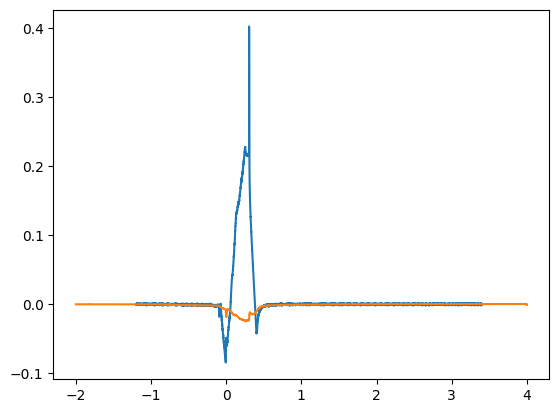

In [68]:
source = 'amb'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)

pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)

ds = dataset['ccbv'].dropna(dim='time')
plt.plot(ds.time, ds.values[0])

ds = dataset['obv'].dropna(dim='time')
plt.plot(ds.time, ds.values[0])

### AMC - Needs Review

In [19]:
source = 'amc'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

# df = make_channel_df(dataset)
# df.to_csv('amc.csv')

<xarray.Dataset> Size: 5MB
Dimensions:                (time: 30000)
Coordinates:
  * time                   (time) float32 120kB -2.0 -2.0 -2.0 ... 3.999 4.0 4.0
Data variables: (12/46)
    amc/efps_current       (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amc/error_field_02     (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amc/error_field_05     (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amc/p2il_coil_current  (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amc/p2il_feed_current  (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amc/p2iu_coil_current  (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    ...                     ...
    amc/p6u_current        (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amc/plasma_current     (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amc/sol_current        (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amc/status             float32 4B dask.array<chunksize=(), meta=np.ndarray>
    amc/tf_current         (time) float32 120kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amc/version            float32 4B dask.array<chunksize=(), meta=np.ndarray>

### AMH - Needs Review

AMH also needs further tensorising, but we should check with Lucy about groups.

In [20]:
source = 'amh'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'

dt = load_source(path)
# dataset = group_signals_by_source(source, dt)
dataset = pipelines.get(source)(dt)
dataset

# df = make_channel_df(dataset)
# df.to_csv('amh.csv')

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',)

### AMM - Needs Review

Another source that can be hevily tensorized

In [21]:
source = 'amm'
path = f'/common/tmp/sjackson/local_cache2/30420.zarr/{source}'
dt = load_source(path)
# dataset = group_signals_by_source(source, dt)
dataset = pipelines.get(source)(dt)
dataset
# dataset = tensorise_group(dataset, 'incon')
# dataset = tensorise_group(dataset, 'mid')
# dataset = tensorise_group(dataset, 'ring')
# dataset = tensorise_group(dataset, 'rodgr')
# dataset = tensorise_group(dataset, 'vertw')
# dataset = tensorise_group(dataset, 'lhorw')
# dataset = tensorise_group(dataset, 'uhorw')
# dataset

# df = make_channel_df(dataset)
# df.to_csv('amm.csv')

<xarray.Dataset> Size: 19MB
Dimensions:         (time: 30000, incon_channel: 10, mid_channel: 12,
                     ring_channel: 10, rodgr_channel: 12, vertw_channel: 8,
                     lhorw_channel: 6, uhorw_channel: 6)
Coordinates:
  * time            (time) float32 120kB -2.0 -2.0 -2.0 ... 4.0 4.001 4.001
  * incon_channel   (incon_channel) <U11 440B 'amm/incon1' ... 'amm/incon10'
  * mid_channel     (mid_channel) <U9 432B 'amm/mid1' 'amm/mid2' ... 'amm/mid12'
  * ring_channel    (ring_channel) <U10 400B 'amm/ring1' ... 'amm/ring10'
  * rodgr_channel   (rodgr_channel) <U11 528B 'amm/rodgr1' ... 'amm/rodgr12'
  * vertw_channel   (vertw_channel) <U10 320B 'amm/vertw1' ... 'amm/vertw8'
  * lhorw_channel   (lhorw_channel) <U10 240B 'amm/lhorw1' ... 'amm/lhorw6'
  * uhorw_channel   (uhorw_channel) <U10 240B 'amm/uhorw1' ... 'amm/uhorw6'
Data variables: (12/25)
    amm/botcol      (time) float64 240kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amm/endcrown_l  (time) float64 240kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amm/endcrown_u  (time) float64 240kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amm/p2larm1     (time) float64 240kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amm/p2larm2     (time) float64 240kB dask.array<chunksize=(30000,), meta=np.ndarray>
    amm/p2larm3     (time) float64 240kB dask.array<chunksize=(30000,), meta=np.ndarray>
    ...              ...
    mid             (mid_channel, time) float64 3MB dask.array<chunksize=(12, 30000), meta=np.ndarray>
    ring            (ring_channel, time) float64 2MB dask.array<chunksize=(10, 30000), meta=np.ndarray>
    rodgr           (rodgr_channel, time) float64 3MB dask.array<chunksize=(12, 30000), meta=np.ndarray>
    vertw           (vertw_channel, time) float64 2MB dask.array<chunksize=(8, 30000), meta=np.ndarray>
    lhorw           (lhorw_channel, time) float64 1MB dask.array<chunksize=(6, 30000), meta=np.ndarray>
    uhorw           (uhorw_channel, time) float64 1MB dask.array<chunksize=(6, 30000), meta=np.ndarray>

### AMS

In [22]:
source = 'ams'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'dim_0' ('dim_0',)

### ANB

In [23]:
source = 'anb'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',)

### ANE

In [24]:
source = 'ane'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset


<xarray.Dataset> Size: 524kB
Dimensions:            (time: 32768)
Coordinates:
  * time               (time) float32 131kB -0.01 -0.00996 ... 1.301 1.301
Data variables:
    ane/co2            (time) float32 131kB dask.array<chunksize=(32768,), meta=np.ndarray>
    ane/density        (time) float32 131kB dask.array<chunksize=(32768,), meta=np.ndarray>
    ane/hene           (time) float32 131kB dask.array<chunksize=(32768,), meta=np.ndarray>
    ane/passnumber     float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ane/status         float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ane/status_detail  float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ane/version        float32 4B dask.array<chunksize=(), meta=np.ndarray>

### ANT

In [25]:
source = 'ant'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset


<xarray.Dataset> Size: 20B
Dimensions:           ()
Coordinates:
    time              float32 4B 0.0
Data variables:
    ant/neutron_dose  float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ant/passnumber    float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ant/status        float32 4B dask.array<chunksize=(), meta=np.ndarray>
    ant/version       float32 4B dask.array<chunksize=(), meta=np.ndarray>

### ANU

In [26]:
source = 'anu'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',)

### AOE - Needs Review

Requires further work! Time ranges are different!

In [27]:
source = 'aoe'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)

dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 21MB
Dimensions:         (time_full: 262144, time: 749850)
Coordinates:
  * time_full       (time_full) float32 1MB 2.384e-07 2.238e-06 ... 0.5243
  * time            (time) float32 3MB 0.27 0.27 0.27 0.27 ... 0.285 0.285 0.285
Data variables:
    aoe/co2_frac    (time_full) float32 1MB dask.array<chunksize=(65536,), meta=np.ndarray>
    aoe/fast_k      (time) float32 3MB dask.array<chunksize=(93732,), meta=np.ndarray>
    aoe/fast_ka     (time) float32 3MB dask.array<chunksize=(93732,), meta=np.ndarray>
    aoe/fast_sync   (time) float32 3MB dask.array<chunksize=(93732,), meta=np.ndarray>
    aoe/fast_u      (time) float32 3MB dask.array<chunksize=(93732,), meta=np.ndarray>
    aoe/k_band      (time_full) float32 1MB dask.array<chunksize=(65536,), meta=np.ndarray>
    aoe/ka_band     (time_full) float32 1MB dask.array<chunksize=(65536,), meta=np.ndarray>
    aoe/passnumber  float32 4B dask.array<chunksize=(), meta=np.ndarray>
    aoe/ramping     (time_full) float32 1MB dask.array<chunksize=(65536,), meta=np.ndarray>
    aoe/status      float32 4B dask.array<chunksize=(), meta=np.ndarray>
    aoe/u_band      (time_full) float32 1MB dask.array<chunksize=(65536,), meta=np.ndarray>
    aoe/version     float32 4B dask.array<chunksize=(), meta=np.ndarray>

### ARP

In [28]:
source = 'arp'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',)

### ASB

In [29]:
source = 'asb'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 636B
Dimensions:           (time: 52)
Coordinates:
  * time              (time) float32 208B -0.015 0.002204 ... 0.8452 0.8624
Data variables:
    asb/cii_dga       (time) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>
    asb/oii_dga       (time) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>
    asb/passnumber    int32 4B dask.array<chunksize=(), meta=np.ndarray>
    asb/status        int32 4B dask.array<chunksize=(), meta=np.ndarray>
    asb/svn_revision  float32 4B dask.array<chunksize=(), meta=np.ndarray>

### ASM - Needs Review
Another one which needs to be tensorized

In [30]:
source = 'asm'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset
# df = make_channel_df(dataset)
# df.to_csv('asm.csv')

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',)

### ASX - Needs Review

Time has two values, but these differ between variables.

In [31]:
source = 'asx'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)

dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 92B
Dimensions:                   (npts: 2)
Coordinates:
    time                      float32 4B 0.0
Dimensions without coordinates: npts
Data variables:
    asx/elm_freqs             (npts) float32 8B -0.01 -0.00998
    asx/elmy                  (npts) float32 8B -0.01 -0.00998
    asx/large_scale           (npts) float32 8B 0.0 0.0
    asx/low_cam_nos_sawt_inv  (npts) float32 8B 0.0 0.0
    asx/lower_false_inv_rad   (npts) float32 8B 0.0 0.0
    asx/modes                 (npts) float32 8B 0.0 0.0
    asx/passnumber            int32 4B dask.array<chunksize=(), meta=np.ndarray>
    asx/sawteeth              (npts) float32 8B 0.0 0.0
    asx/sawtooth_periods      (npts) float32 8B 0.0 0.0
    asx/status                int32 4B dask.array<chunksize=(), meta=np.ndarray>
    asx/up_cam_nos_sawt_inv   (npts) float32 8B 0.0 0.0
    asx/upper_false_inv_rad   (npts) float32 8B 0.0 0.0

### AYC

In [32]:
source = 'ayc'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',)

### AYE

In [33]:
source = 'aye'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
dataset = pipelines.get(source)(dt)
dataset

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'time' ('time',)

### EFM - Needs Review
Needs more work

0 -1 is normalised psi

psi - psi_norm - areap_c
dim_0 - num_iterations - chisq_magnetic
psi - psi_norm -  elongpsi_c
dim_0 - fcoil_segs_n - fcoil_ang1
dim_0 - fcoil_segs_n - fcoil_ang2
dim_0 - fcoil_n - fcoil_c
dim_0 - fcoil_n - fcoil_chisq
dim_0 - ffprime_coefs_n - ffprime_coefs
dim_0 - magpr_n - fwtmp
dim_0 - silop_n - fwtsi
dim_0 - nr - gridr
dim_0 - nz - gridz
r - nr_prof - jr
dim_0 - limiter_n - limiterr
dim_0 - limiter_n - limiterz
dim_0 - magpr_n - magpr_ang
z/r - nz/nr - plasma_currrz

pprime_coefs - as ffprime
r - nr_prof - pr_c
r - nr_prof - psir
height/radius - nz/nr - psirz
psi - psi_norm - pwpsi_c
r - nr_prof - qr
r - nr_prof - rvals - rvals for the radial profiles

dim_0 - silop_n - silop_c
dim_0 - silop_n - silop_chisq

In [34]:
from src.archive.transforms import MergeDatasets


source = 'efm'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)

pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset

# # df = pd.DataFrame(items)
# # df.to_csv('efm.csv')

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'nprof_r' ('nprof_r',)

### ESM - Needs Review

ibmp1_r_larmor and similar can be dropped if unity.

In [35]:
source = 'esm'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'

dt = load_source(path)
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset

# df = pd.DataFrame(items)
# df.to_csv('esm.csv')
# dataset

<xarray.Dataset> Size: 550kB
Dimensions:                   (time: 52, fit_quality_n: 2, time_multi: 69,
                               time_ane: 32768, radius: 130, time_r_multi: 8970)
Coordinates:
  * time                      (time) float32 208B 0.03 0.035 0.04 ... 0.28 0.285
  * fit_quality_n             (fit_quality_n) float32 8B -999.0 -1e+03
  * time_multi                (time_multi) float32 276B 0.00416 ... 0.2875
  * time_ane                  (time_ane) float32 131kB -0.01 -0.00996 ... 1.301
  * radius                    (radius) float32 520B 0.0 1.0 2.0 ... 128.0 129.0
  * time_r_multi              (time_r_multi) float32 36kB 0.2346 ... 1.516
Data variables: (12/79)
    esm/area_outin_ratio      (time) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>
    esm/av_t                  float32 4B dask.array<chunksize=(), meta=np.ndarray>
    esm/dr_sep_in             (time) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>
    esm/dr_sep_out            (time) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>
    esm/efm_comb_ratingav     (fit_quality_n) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    esm/efm_comb_ratingmin    (fit_quality_n) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    ...                        ...
    esm/v_ion                 float32 4B dask.array<chunksize=(), meta=np.ndarray>
    esm/v_ion_multi           (time_multi, radius) float32 36kB dask.array<chunksize=(69, 130), meta=np.ndarray>
    esm/v_loop_dynamic        (time) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>
    esm/v_loop_static         (time) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>
    esm/w_dot                 (time) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>
    esm/x                     (time) float32 208B dask.array<chunksize=(52,), meta=np.ndarray>

### ESX

In [36]:
source = 'esx'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
# dataset = group_signals_by_source(source, dt)
# dataset
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 48B
Dimensions:               (time: 2)
Coordinates:
  * time                  (time) float32 8B 0.0 0.0
Data variables:
    esx/lower_inv_psi     (time) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    esx/lower_inv_radius  (time) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    esx/passnumber        float32 4B dask.array<chunksize=(), meta=np.ndarray>
    esx/status            float32 4B dask.array<chunksize=(), meta=np.ndarray>
    esx/upper_inv_psi     (time) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>
    esx/upper_inv_radius  (time) float32 8B dask.array<chunksize=(2,), meta=np.ndarray>

### XDC

In [37]:
source = 'xdc'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 115MB
Dimensions:                     (time0: 40000, time: 21000, time4: 2000,
                                 time6: 200, time2: 19900, time5: 1900,
                                 time7: 190, time3: 1100, ai_ccbv_channel: 40,
                                 ai_flcc_channel: 10, ai_incon_channel: 10,
                                 ai_lhorw_channel: 6, ai_mid_channel: 12,
                                 ai_obr_channel: 19, ai_obv_channel: 19,
                                 ...
                                 isoflux_t_seg_td_channel: 13,
                                 isoflux_t_seg_ti_channel: 13,
                                 isoflux_t_seg_tp_channel: 13,
                                 isoflux_t_seg_u_channel: 18,
                                 isoflux_t_zpsh_n_channel: 18,
                                 isoflux_t_zpsh_p_channel: 18)
Coordinates: (12/22)
  * time0                       (time0) float64 320kB -2.0 -2.0 -2.0 ... 2.0 2.0
  * time                        (time) float64 168kB -0.1 -0.0999 ... 2.0 2.0
  * time4                       (time4) float64 16kB 0.0 0.001 ... 1.998 1.999
  * time6                       (time6) float64 2kB 0.0 0.01 0.02 ... 1.98 1.99
  * time2                       (time2) float64 159kB 0.01 0.0101 ... 2.0 2.0
    dim_0                       int32 4B 0
    ...                          ...
  * isoflux_t_seg_td_channel    (isoflux_t_seg_td_channel) <U21 1kB 'xdc/isof...
  * isoflux_t_seg_ti_channel    (isoflux_t_seg_ti_channel) <U21 1kB 'xdc/isof...
  * isoflux_t_seg_tp_channel    (isoflux_t_seg_tp_channel) <U21 1kB 'xdc/isof...
  * isoflux_t_seg_u_channel     (isoflux_t_seg_u_channel) <U20 1kB 'xdc/isofl...
  * isoflux_t_zpsh_n_channel    (isoflux_t_zpsh_n_channel) <U21 2kB 'xdc/isof...
  * isoflux_t_zpsh_p_channel    (isoflux_t_zpsh_p_channel) <U21 2kB 'xdc/isof...
Dimensions without coordinates: ai_ccbv_channel, ai_flcc_channel,
                                ai_incon_channel, ai_lhorw_channel,
                                ai_mid_channel, ai_obr_channel, ai_obv_channel,
                                ai_ring_channel, ai_rodgr_channel,
                                ai_uhorw_channel, ai_vertw_channel, ai_ccbv,
                                equil_seg_channel
Data variables: (12/996)
    xdc/ai_cpu1_botcol          (time0) float32 160kB dask.array<chunksize=(40000,), meta=np.ndarray>
    xdc/ai_cpu1_camera_ok       (time0) float32 160kB dask.array<chunksize=(40000,), meta=np.ndarray>
    xdc/ai_cpu1_co2             (time0) float32 160kB dask.array<chunksize=(40000,), meta=np.ndarray>
    xdc/ai_cpu1_endcrown_l      (time0) float32 160kB dask.array<chunksize=(40000,), meta=np.ndarray>
    xdc/ai_cpu1_endcrown_u      (time0) float32 160kB dask.array<chunksize=(40000,), meta=np.ndarray>
    xdc/ai_cpu1_flp2l1          (time0) float32 160kB dask.array<chunksize=(40000,), meta=np.ndarray>
    ...                          ...
    isoflux_t_seg_td            (isoflux_t_seg_td_channel, time5) float32 99kB dask.array<chunksize=(13, 1900), meta=np.ndarray>
    isoflux_t_seg_ti            (isoflux_t_seg_ti_channel, time5) float32 99kB dask.array<chunksize=(13, 1900), meta=np.ndarray>
    isoflux_t_seg_tp            (isoflux_t_seg_tp_channel, time5) float32 99kB dask.array<chunksize=(13, 1900), meta=np.ndarray>
    isoflux_t_seg_u             (isoflux_t_seg_u_channel, time5) int32 137kB dask.array<chunksize=(18, 1900), meta=np.ndarray>
    isoflux_t_zpsh_n            (isoflux_t_zpsh_n_channel, time5) float32 137kB dask.array<chunksize=(18, 1900), meta=np.ndarray>
    isoflux_t_zpsh_p            (isoflux_t_zpsh_p_channel, time5) float32 137kB dask.array<chunksize=(18, 1900), meta=np.ndarray>

### XPC

In [38]:
source = 'xpc'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset

<xarray.Dataset> Size: 8MB
Dimensions:               (time1: 130000, time: 8000)
Coordinates:
  * time1                 (time1) float32 520kB -0.1 -0.1 -0.09999 ... 0.55 0.55
  * time                  (time) float32 32kB -0.1 -0.0998 -0.0996 ... 1.5 1.5
Data variables: (12/74)
    xpc/a14_0116#06       (time1) float32 520kB dask.array<chunksize=(65000,), meta=np.ndarray>
    xpc/a14_0118#03       (time1) float32 520kB dask.array<chunksize=(65000,), meta=np.ndarray>
    xpc/a14_0118#06       (time1) float32 520kB dask.array<chunksize=(65000,), meta=np.ndarray>
    xpc/chfs_drive        (time1) float32 520kB dask.array<chunksize=(65000,), meta=np.ndarray>
    xpc/clamp_p1_drive    (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    xpc/clamp_p2_drive    (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    ...                    ...
    xpc/trcf_0104_16      (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    xpc/trcf_0104_5       (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    xpc/trcf_0104_6       (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    xpc/trcf_0104_9       (time) float32 32kB dask.array<chunksize=(8000,), meta=np.ndarray>
    xpc/z_d_f_b           (time1) float32 520kB dask.array<chunksize=(65000,), meta=np.ndarray>
    xpc/zip_velocity      (time1) float32 520kB dask.array<chunksize=(65000,), meta=np.ndarray>

### XSX

In [39]:
source = 'xsx'
path = f'/common/tmp/sjackson/local_cache2/30397.zarr/{source}'
dt = load_source(path)
pipelines = PipelineRegistry()
dataset = pipelines.get(source)(dt)
dataset

ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'dim_0' ('dim_0',)